# Tensorflow for Image Recognition

### What is Tensorflow?
Tensorflow is an open source library that allows users to perform numerical computations through **Data Flow graphs**. A Data Flow graph (DFG) is a Directed Cyclic/Acyclic graph that corresponds to a representation of mathematical operations that showcases data dependencies. Using Graph Terminologies, nodes in a DFG are operators that can have multiple inputs and multiple outputs whereas edges correspond to the flowing data. When the data is processed and ready to be fed in as an input to a node, the nodes perform the required computations to generate output(s). This output can then be further accessed by other nodes. In Tensorflow teminology, nodes in a DFG are known as an **Operand (Ops)** (which generally are mathematical operators) and we will be using the term *Ops* throughout this tutorial.

### Tensorflow and Data Science
As the amount of data being generated every minute is increasing rapidly, the need to process and then analyze this huge amount of data is a substantial task in the process of data science. Keeping this in mind, Tensorflow's framework has been designed to assist faster processing of large datasets. The `tf.data` API enables the programmers to develop input pipelines for fetching their data from a Distributed File System (DFS), apply multiple preprocessing steps to *clean* the data and finally perform the tasks of random shuffling and batching to feed the data piecewise to a prediction model.

Tensorflow provides its libraries to be used as packages in Python (which can be used with libraries like `pandas` and `numpy`) along with a C++ API. To visualize operations, data flow in models and end results, Tensorflow also provides a visualization tool known as **Tensorboard** which would be covered later in this tutorial.

### Structure of a Tensorflow Program
A program in Tensorflow *always* consists of two parts - building a DFG and executing the required parts in the built graph. Formally, a TF computational graph is a *Directed Acyclic graph (DAG)* where nodes are called *Operands* and these Ops produces `tensors`. Finally, these `tensors` flow around in the graph through edges. Let's build a simple DFG to multiply two matrices and see how the output looks like.    


In [14]:
import os
import tensorflow as tf
import numpy as np
from IPython.display import Image
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2" # Extremely important (not really) to suppress unnecessary warnings! 

In [2]:
def build_tf_graph():
    x = tf.constant ([[0, -2, 3], [-1, -31, -7]], dtype=tf.int32)
    y = tf.constant ([[1, 1, 1, 3], [7,  -1, 9, 4], [-9, 3, 8, 5]], dtype=tf.int32)
    z = tf.matmul(x, y)
    return x, y, z

def main():
    x, y, z = build_tf_graph() # Note that nothing has been executed so far. 
    print (z, type(z))

In [3]:
main()

Tensor("MatMul:0", shape=(2, 4), dtype=int32) <class 'tensorflow.python.framework.ops.Tensor'>


It is important to note that executing the nodes of a graph and building a graph are two very different things in Tensorflow. We can see that `z` is a tf operand and belongs to `tensorflow.python.framework.ops.Tensor` class.

In [4]:
def main():
    x, y, z = build_tf_graph() # Note that nothing has been executed so far. 
    with tf.Session() as sess: # Session created to execute parts of the graph
        output = sess.run(z) # Execute the graph and fetch me the operand "z" 
        print(output)
        
main()

[[ -41   11    6    7]
 [-155    9 -336 -162]]


Creating a tf session creates an environment to execute operands. Hence, to get the output, we do a `sess.run(operand)`. This command starts executing all the nodes that are required to fire to get the output. Here's what the graph looks like.  

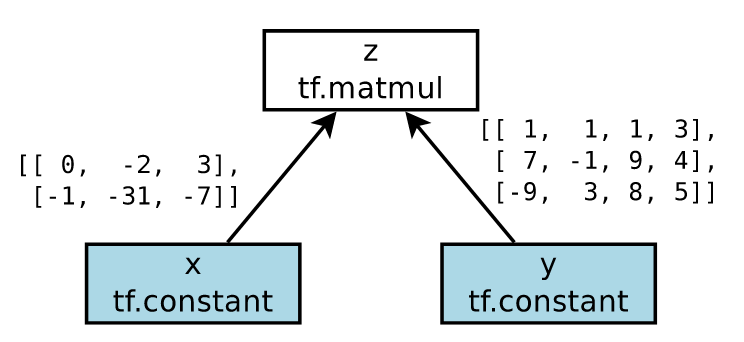

In [5]:
Image(filename="images/tf_simple.png")

Operands like `tf.constant` (value never changes), `tf.Variable` (value can change) etc. do not really interact with the user. What if the user wants to input something in the graph? At the very least, we want to *feed* the data we have in the graph to do the computations for us. For this, we have a tf operand known as `placeholder`. This operand lets the user *feed* in a particular value into the graph while *executing* the graph. Lets see how that works.

**Note** that a tf operand always starts with a lowercase character, ie. `tf.placeholder`, `tf.get_variable`, `tf.constant`. However, `tf.Variable` is a class of tf operands and hence starts with an uppercase character.

In [6]:
def build_placeholder_graph():
    with tf.variable_scope("fixed_x", reuse = tf.AUTO_REUSE): # Scope defined to create/fetch a variable in/from.
        x_fixed = tf.get_variable(name = "tf_x", dtype = tf.int32, shape = [1, 2]) # Shape = (1, 2)
    
    x_not_fixed = tf.placeholder(dtype = tf.int32, shape = [None, 2]) # Shape = (?, 2)
    
    y = tf.random_uniform(dtype = tf.int32, shape = [2, 2], minval = 0, maxval = 3) # Shape = (2, 2) 
    
    multiply_fixed = tf.matmul(x_fixed, y) # Returns an operand of shape (1, 2)
    multiply_not_fixed = tf.matmul(x_not_fixed, y) # Returns an operand of shape (?, 2) 
    
    # Notice how we are returning a dictionary of tf operands instead of a list. This is considered to be a good practice!
    return {
        "fixed" : multiply_fixed,
        "not_fixed" : multiply_not_fixed,
        "input" : x_not_fixed
    }

def main():
    tf_ops = build_placeholder_graph() # tf_ops has all the required operands of the graph
    
    input_x = np.asarray([[3, 2], [2, 1], [1, 0]]) # ? depends on the shape of input_x. Here, ? = 3
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer()) # This line initializes the uninitialized variables in the graph
        
        # We pass in a list of operands we want to execute. Here, we execute the operands "fixed" and "not_fixed"
        # "feed_dict" arguments expects a (Key : Value) pair where Key is a tf operand and value is the input we want to feed in.
        f, v = sess.run([tf_ops["fixed"], tf_ops["not_fixed"]], feed_dict = {tf_ops["input"] : input_x})
        
        print("Shape of x_not_fixed = {}".format(tf_ops["not_fixed"].get_shape()))
        
        print("Fixed Sized Matrix Multiplication = {}".format(f))
        print("Variable Sized Matrix Multiplication = \n{}".format(v))

main()

Shape of x_not_fixed = (?, 2)
Fixed Sized Matrix Multiplication = [[0 0]]
Variable Sized Matrix Multiplication = 
[[6 8]
 [4 5]
 [2 2]]


To create a new variable of a fixed shape or fetch an already created variable by that name (tf operand name), we call `tf.get_variable` with the shape parameter. This operand requires a scope to create a variable in or fetch from. Hence, we put `tf.get_variable()` inside a scope defined by `tf.variable_scope()`. To reuse this same variable named `tf_x`, we pass the parameter `reuse = tf.AUTO_REUSE`.

Now, it is impossible to know the size of the data we are going to work with. For this, we can pass in the value `None` in the shape argument of a placeholder. This informs the operand to adjust according to the value that comes in while executing the graph. In our case, the shape of `x_not_fixed` would be (?, 2). As we will see later in our Tensorboard visualizations, `?` denotes an unknown value (only to be computed upon execution).   

## Image Recognition

Let's start with something simple. In this and the coming sections, we deal with the task of recognizing hand written digits in the MNIST data set. This task has been experimented upon for a long time now and people have come up with many intricate Neural Network Architectures to solve this problem. For this tutorial, we will design a `single layered neural network` and use `gradient descent optimization` technique to reduce our `losses`. Lets define the highlighted terms first.

##### Single Layered Neural Network
To understand Neural Networks (NN), we need to understand their building blocks *perceptrons*, broadly, the perceptron algorithm. The main idea behind perceptron algorithm is to learn the values of the weights `w` that are then multiplied with the input features in order to make a decision whether a perceptron fires or not, ie. we use the product of our input features `X` and the weights `W` (that we are going to learn) to determine the output of *each* perceptron.
$$
\sum_{m = 0}^{\#\tt{features}} W_{m} X_{m} + bias
$$

If we have `m` number of features and `k` number of perceptrons, our weights then change from a vector of length `k` to a matrix of dimension `k X m`. Similarly, our scalar `bias` changes to a vector `b` of length `k`.

##### Gradient Descent and Loss
Being a continuous function, one of the biggest advantages of the linear equation that we defined above is that it is differentiable. This property allows us to define a cost function `L(w)` that we can minimize in order to update our weights. In this case, we define `L(w)` as a cross entropy function between our outputs for each perceptron and the correct labels for the image. Now, as we have 10 outputs, we use 10 perceptrons. To define a probability distribution over our output labels, we use the softmax function for it. Softmax function is defined as 
$$
O_{i} = \frac{\exp(O_i)}{\sum_{j = 0}^{10} \exp(O_{j})}
$$
where 
$$
O_{j} = \sum_{m = 0}^{\#\tt{features}}W_{m} X_{m} + bias
$$
Hence, we can define our loss function as 
$$
L(w) = \sum_{n} -p_{n} \log q_{n}
$$
where `n` are the total number of training examples, `q` is the softmax output of our model (which is a vector of length `10`) and `p` is the correct probability distribution. As we are sure about our outputs, `p` can instead be thought of as a one-hot vector.  

**Please note** that we generally do not perform vanilla gradient descent when our dataset is large enough to have variances. We perform Mini-Batch gradient descent and update our parameters `W` and `b` after passing each batch. For more details, visit this [link](https://stats.stackexchange.com/questions/232056/how-could-stochastic-gradient-descent-save-time-comparing-to-standard-gradient-d/232058#232058) or take one of the many courses (11-785, 10-701, etc) offered in CMU. In this tutorial, we do Mini-Batch gradient descent.

### Data Collection

Tensorflow has a pre-defined package to handle importing the byte image train, validation and test files. As we are using MNIST dataset, we use the `tensorflow.examples.tutorials.mnist` package to import the dataset. We place all of our byte files in the `data` directory. **(To download the dataset, please visit [this](http://yann.lecun.com/exdb/mnist/) link and download all the 4 files.)**

In [7]:
from tensorflow.examples.tutorials.mnist import input_data
mnist_data = input_data.read_data_sets("data/", one_hot = True)

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz


### Building the graph

Before defining the graph required, we start with defining a `class` for storing all the hyperparamters. 

In [8]:
class Hparams:
    def __init__(self):
        self.learning_rate = 0.001
        self.num_epochs = 30
        self.batch_size = 32
        self.path_to_logs = "logs/"
        self.log_freq = 10
        

Now we define the graph. MNIST dataset consists of images of size `28 X 28`. Hence, our `X` would be a matrix of dimension `batch_size X 784`. As batch size is a hyper parameter, we would want to check the performace of our classification model by varying the batch sizes. For handling this issue, we use a `placeholder` operand. Below is the code that does that. Along with performing gradient descent, we also define our evaluation metric.

**Due to an upper bound on the number of lines of code, I will be adding certain flags operands like `tf.summary.scalar()` that are used in Tensorboard for visualization purposes.**

In [9]:
def build_mnist_graph():
    
    # X is our input image and y are our labels
    X = tf.placeholder(dtype = tf.float32, shape = [None, 784], name = "X")
    y = tf.placeholder(dtype = tf.float32, shape = [None, 10], name = "y")
    
    # As described above, we now define our weights and biases
    with tf.variable_scope("params", reuse = tf.AUTO_REUSE):
        weights = tf.get_variable("weight", shape = [784, 10])
        bias = tf.get_variable("bias", shape = [10])
        
    product = tf.matmul(X, weights, name = "product")
    output = tf.add(product, bias, name = "output")
    
    # As defined above, we get the probability distribution over our output labels using the softmax function
    probabilities = tf.nn.softmax(output, name = "probabilities")
    
    """
    Lets define our loss. Here, reduction_indices tells the axis on which to sum on.
    We sum over all the 10 values for each training example. Loss would then be a vector of length "batch_size".
    Finally we take the mean of all the values and reduce over that scalar value.
    """
    loss = - tf.reduce_sum(y * tf.log(probabilities), reduction_indices = 1)
    mean_loss = tf.reduce_mean(loss, name = "final_mean")
    
    #Lets start the optimization
    optimizer = tf.train.GradientDescentOptimizer(hp.learning_rate)
    start_training = optimizer.minimize(mean_loss)
    
    """
    To get our and correct prediction values, we do argmax over our variables.
    Doing argmax over y is essentially equal to finding the index where the value is 1 as rest of the values are 0. 
    """
    equalities = tf.equal(tf.argmax(output, axis = 1), tf.argmax(y, axis = 1))
    accuracy = tf.reduce_mean(tf.cast(equalities, tf.float32))
    
    # Operands that help us visualize the value of these operands when we feed in the data
    tf.summary.scalar("Loss", mean_loss)
    tf.summary.scalar("Accuracy", accuracy)
    # Finally, we merge these two accuracies to see them on a single board.
    merged_summary = tf.summary.merge_all()
    
    return {
        "X" : X,
        "y" : y,
        "loss" : mean_loss,
        "accuracy" : accuracy,
        "start_training" : start_training,
        "summary" : merged_summary
    }

In [10]:
# Listing out our hyperparamters
hp = Hparams()

# Lets execute our model now. Remember, all these are just operands till now!
graph = tf.Graph()
with graph.as_default():
    tf_ops = build_mnist_graph()
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        # Summary writer operand to write the values out to the tensorboard
        write_to_log = tf.summary.FileWriter(hp.path_to_logs, graph = graph)
        # Lets start training!
        print("Training the model...")
        for epoch in range(hp.num_epochs):
            total_loss = 0.0
            num_batches = mnist_data.train.num_examples // hp.batch_size + 1
            for batch in range(num_batches):
                # The TF API randomly shuffles and creates batches from the examples
                b_X, b_y = mnist_data.train.next_batch(hp.batch_size)
                waste, loss, accuracy, summary = sess.run([tf_ops["start_training"], 
                                                  tf_ops["loss"],
                                                  tf_ops["accuracy"],
                                                  tf_ops["summary"]],
                                                 feed_dict = {
                                                     tf_ops["X"] : b_X,
                                                     tf_ops["y"] : b_y
                                                 })
                # Adding Summary to the summary operand
                if (batch + 1) % hp.log_freq == 0:
                    write_to_log.add_summary(summary, epoch * num_batches + batch)
                total_loss += (loss / hp.batch_size)
            print("Loss after epoch {} = {}".format(epoch + 1, total_loss))
                
            
        

Training the model...
Loss after epoch 1 = 91.3079260662198
Loss after epoch 2 = 58.90194701589644
Loss after epoch 3 = 46.745094881393015
Loss after epoch 4 = 40.49899931345135
Loss after epoch 5 = 36.63662977516651
Loss after epoch 6 = 33.992332053370774
Loss after epoch 7 = 32.04072577599436
Loss after epoch 8 = 30.532467912882566
Loss after epoch 9 = 29.33749464387074
Loss after epoch 10 = 28.366438768338412
Loss after epoch 11 = 27.495483350008726
Loss after epoch 12 = 26.80893585179001
Loss after epoch 13 = 26.187203572597355
Loss after epoch 14 = 25.65238145040348
Loss after epoch 15 = 25.165442693978548
Loss after epoch 16 = 24.74691257206723
Loss after epoch 17 = 24.35240384703502
Loss after epoch 18 = 23.991920473985374
Loss after epoch 19 = 23.669666246511042
Loss after epoch 20 = 23.41548334574327
Loss after epoch 21 = 23.119404025841504
Loss after epoch 22 = 22.845342990010977
Loss after epoch 23 = 22.651672364212573
Loss after epoch 24 = 22.42539268033579
Loss after epoch

## Tensorboard Visualizations

Now that our loss is decreasing, lets see how it is decreasing. Using `tf.summary.scalar`, tf was adding all these scalar values in its logs which can be used by Tensorboard and shown on a user-interactive interface. Along with visualizing how our scalars look like, we can visualize the entire graph mapped by Tensorflow.

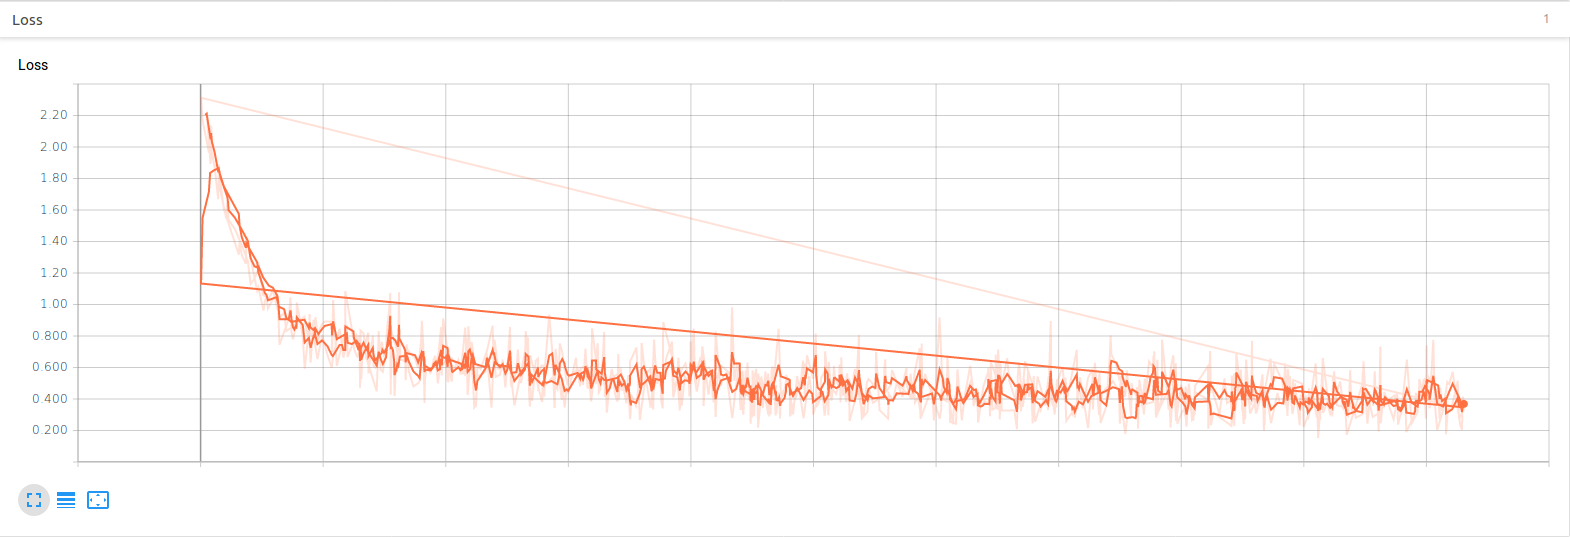

In [11]:
# Loss graph
Image(filename="images/loss.png")

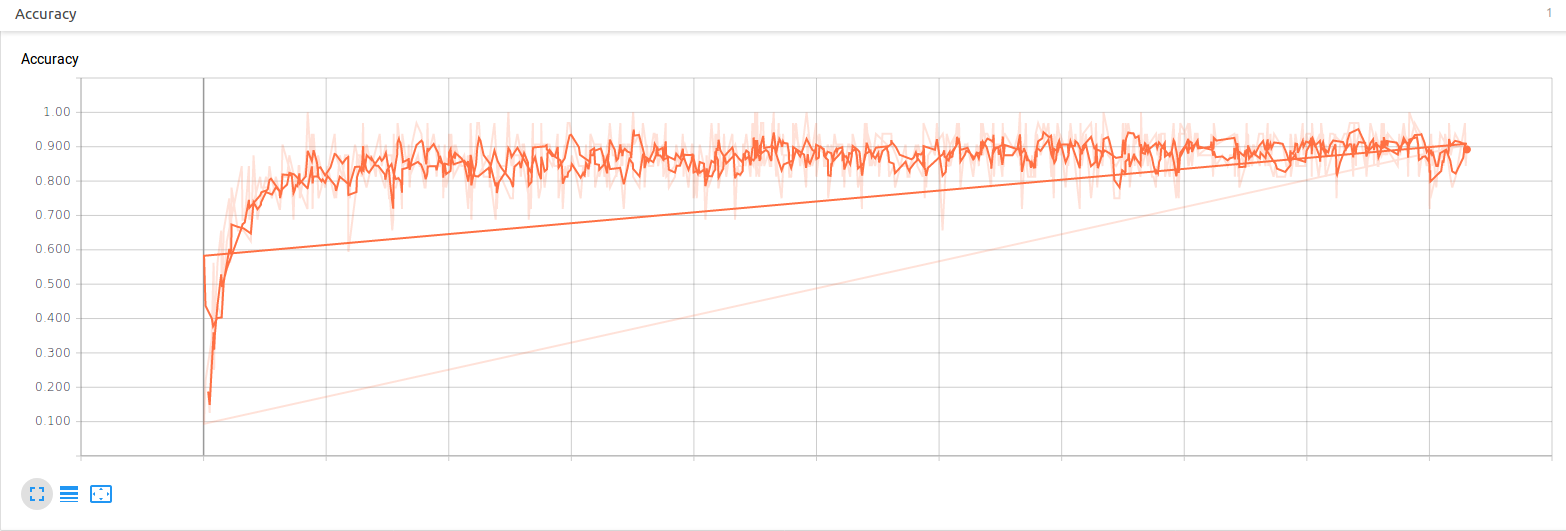

In [12]:
# Accuracy graph
Image(filename="images/acc.png")

Below we have the graph panned out for our model. Lets try and understand what it denotes. Remember that this is not a static but a user interactive graph. On clicking the nodes and the edges, it tells us various different parameters that can be further explored for improving the model.

Right at the bottom of the graph, we have our input `X` and a big `params` block that consists of variables (`bias` and `weights`) and our optimizers. Each edge flowing in or out of the node represents data flow. Hence, the edge coming out of `X` has a shape of `? X 784` which syncs up with the way we initialized our graph. Our `X` is then multiplied with a paramter of shape `784 X 10` in an operand named `product` (mentioned in the code) which gives an output of shape `? X 10`. This is then added with a bias which is then fed to operands `probabilities` (on the left) and `argmax` for softmax and accuracy calculation respectively. 

The mini-block gradient at multiple nodes denotes which operands needs to back-propagated on to calculate gradient and weight updates. As evident from the graph, Tensorboard can be immensely useful for understanding the flow of our data in the entire pipeline.

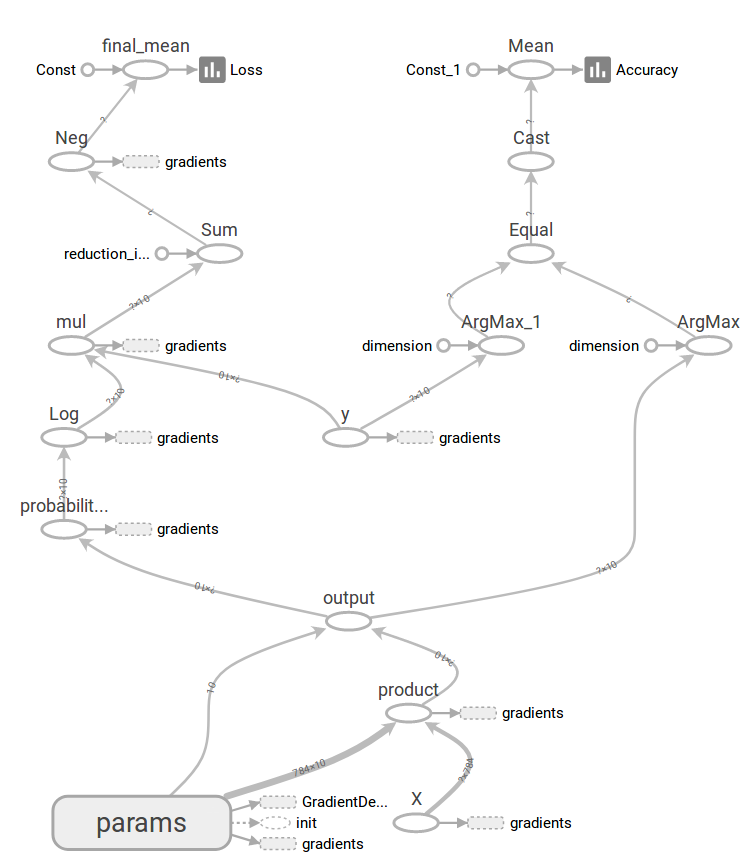

In [13]:
Image(filename="images/main_graph.png")

### References

1. [Tensorflow](https://www.tensorflow.org/)
2. [Google's Tensorboard](https://www.tensorflow.org/programmers_guide/summaries_and_tensorboard)
3. [CMU 11-695](http://www.cs.cmu.edu/afs/cs/user/hieup/www/11695/)